In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
%matplotlib inline


In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/DE_Simulation.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

#Define Setting

In [0]:
df_input = df[['ds', 'simulated']]
df_input = df_input.rename(columns = {'simulated' : 'activations'})
df_input['ds'] =  pd.to_datetime(df_input['ds'])
df_input.head()

,ds,activations
0,2018-01-07 00:00:00+00:00,5471.0
1,2018-01-14 00:00:00+00:00,5228.0
2,2018-01-21 00:00:00+00:00,5489.0
3,2018-01-28 00:00:00+00:00,5114.0
4,2018-02-04 00:00:00+00:00,6961.0


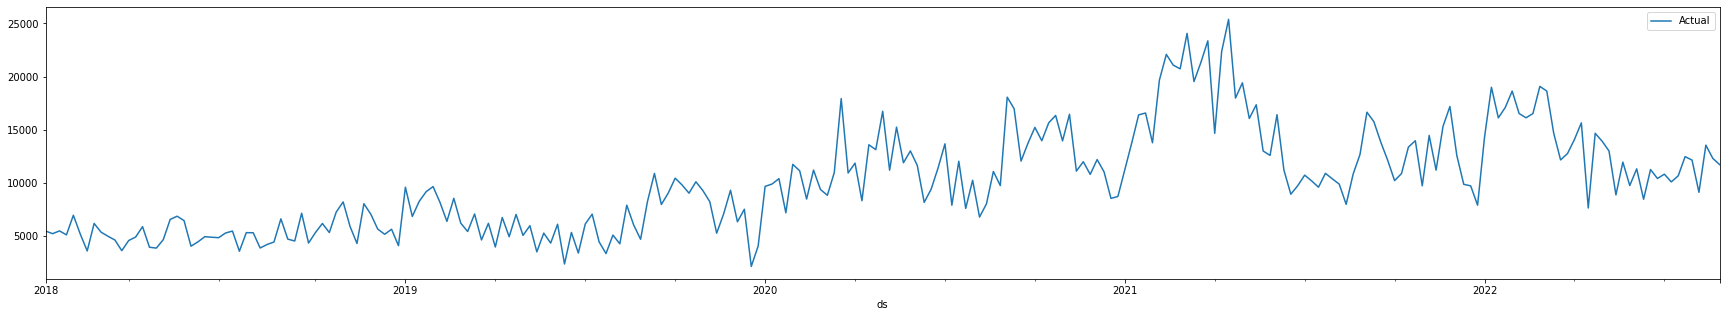

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_input.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
plt.legend()
plt.show()

In [0]:
before_covid_df = df_input.iloc[0:113] ##from 2018-01-07 to 2020-03-01
in_covid_df = df_input.iloc[113:217] ##from 2020-03-08 to 2022-02-27. >> two-year cycle
after_covid_df = df_input.iloc[217:] ##from 2022-03-06 to 2022-08-28
no_covid_df = before_covid_df.append(after_covid_df)
print('before:',len(before_covid_df), ', in:',len(in_covid_df), ', after:', len(after_covid_df), ', no covid:', len(no_covid_df))

before: 113 , in: 104 , after: 26 , no covid: 139


In [0]:
no_covid_df['ds'] = pd.date_range(start='2020-01-01', periods=139, freq='W') ##config the time index to fit in prophet ds

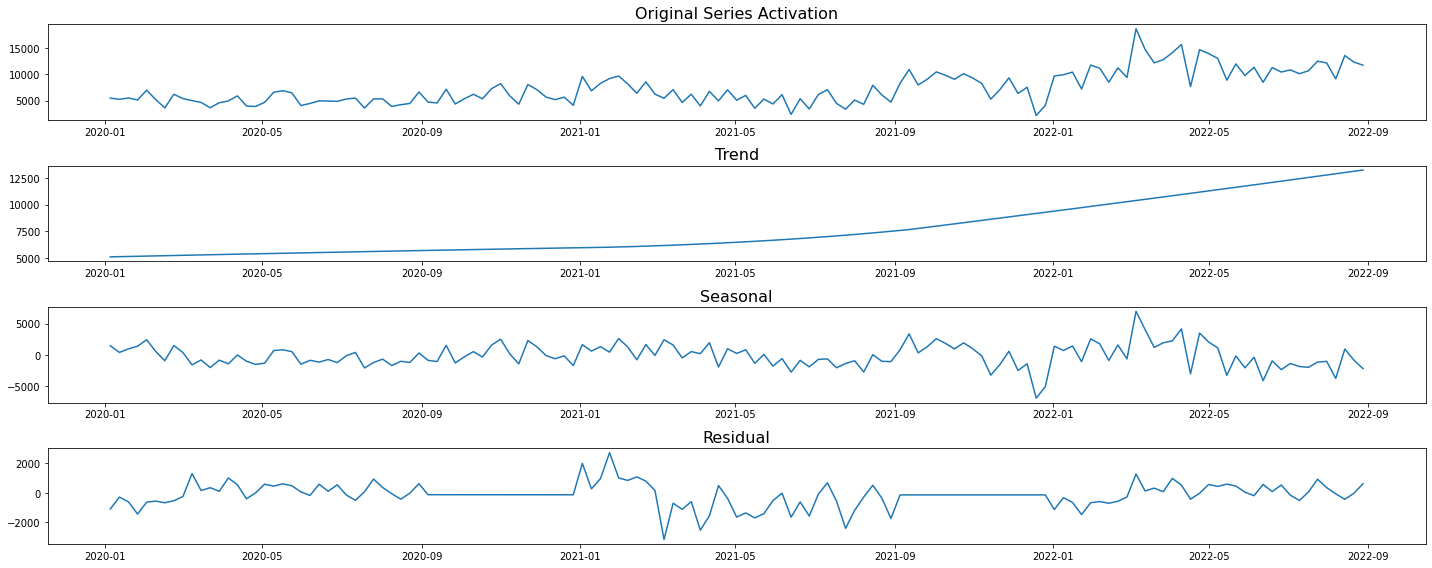

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

stl_conversions = STL(no_covid_df.set_index(['ds']))
result_conversions = stl_conversions.fit()

seasonal_conversions, trend_conversions, resid_conversions = result_conversions.seasonal, result_conversions.trend, result_conversions.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(no_covid_df.set_index(['ds']))
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_conversions)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_conversions)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_conversions)
plt.title('Residual', fontsize=16)

plt.tight_layout()

#Train and Test Split

In [0]:
train_df = no_covid_df.iloc[:int(len(no_covid_df)*0.8)]
train_df_index = train_df.set_index(['ds'])
test_df = no_covid_df.iloc[int(len(no_covid_df)*0.8):]
test_df_index = test_df.set_index(['ds'])

print('train:', len(train_df), ' test:', len(test_df), ' total:', len(no_covid_df))

## train_df >> 01.03 to 27.07
## train_df >> 28.07 to 30.09

train: 111  test: 28  total: 139


#mul-mul

##Train

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


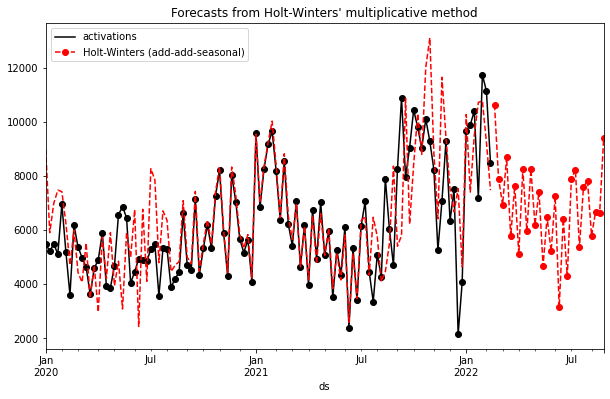

,Additive Dam
alpha,2.171429e-01
beta,1.000000e-04
phi,9.900000e-01
gamma,9.394286e-02
l0,5.304926e+03
b0,1.019757e+00
SSE,2.792309e+08


In [0]:
fit3 = ExponentialSmoothing(
    train_df_index,
    seasonal_periods=52,
    trend='mul',
    seasonal="mul",
    damped_trend=True,
    # initial_level = 0.9,
    # initial_trend = 0.9,
    # initial_seasonal= 0.9,
    initialization_method='estimated',
    freq = 'W',
).fit()


results = pd.DataFrame(
    index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
)

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]

results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

ax = train_df_index.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)

fit3.fittedvalues.plot(ax=ax, style="--", color="red")

fit3.forecast(len(test_df)).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)

plt.show()
results

In [0]:
fit3_df = fit3.fittedvalues.to_frame()
fit3_df_columns = ['activations']
fit3_df.columns = fit3_df_columns
fit3_df.head()

,activations
ds,
2020-01-05,9001.359365
2020-01-12,5906.766247
2020-01-19,6994.957072
2020-01-26,7479.220592
2020-02-02,7422.890606


In [0]:
##historical forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ' + str(r2_score(train_df_index, fit3_df)))
print('MAPE: ' + str(mean_absolute_percentage_error(train_df_index, fit3_df)))
print('RMSE', mean_squared_error(train_df_index, fit3_df, squared=False))

R-aquared: 0.40020939512932774
MAPE: 0.1826482688272464
RMSE 1586.062246455347


##Test

In [0]:
forecast_test= fit3.forecast(len(test_df)).to_frame()
forecast_test = forecast_test.reset_index()
forecast_test.columns = ['ds', 'forecasted_activations']
forecast_test_index = forecast_test.set_index(['ds'])
forecast_test_index.tail()

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,forecasted_activations
ds,
2022-07-31,7826.547492
2022-08-07,5791.826532
2022-08-14,6685.303851
2022-08-21,6641.037516
2022-08-28,9416.440653


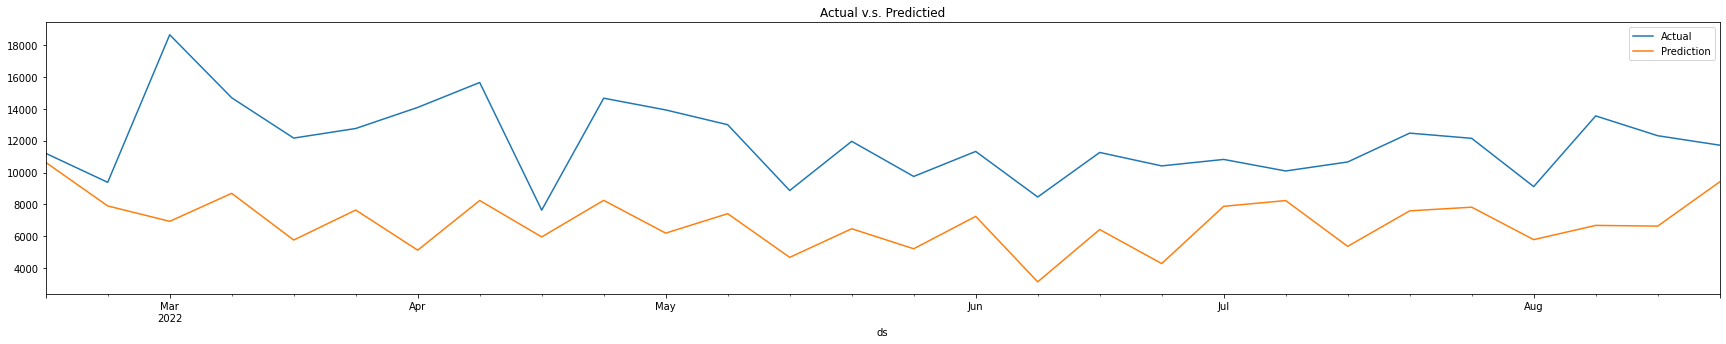

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

test_df.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
forecast_test.plot(kind='line',x='ds', y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

In [0]:
##test forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ', str(r2_score(test_df_index, forecast_test_index)))
print('MAPE: ' , str(mean_absolute_percentage_error(test_df_index, forecast_test_index)))
print('RMSE', mean_squared_error(test_df_index, forecast_test_index, squared=False))

R-aquared:  -4.53143777089979
MAPE:  0.4124054859790313
RMSE 5555.010336047093
